$F(\rho, \sigma) = \operatorname{tr}(\rho \sigma) + 2\sqrt{\det(\rho) \det(\sigma)}$

In [1]:
using Plots
using HDF5
using LinearAlgebra

using QuantumOptics
basis = NLevelBasis(2)

NLevel(N=2)

In [2]:
function det_2x2(matrix)
    # Ensure the matrix is 2x2
    if size(matrix) != (2, 2)
        throw(ArgumentError("Matrix must be 2x2"))
    end

    # Calculate the determinant
    return matrix[1, 1] * matrix[2, 2] - matrix[1, 2] * matrix[2, 1]
end

det_2x2 (generic function with 1 method)

In [3]:
function read_timeevolution(file_name, state, γ)
    h5open(file_name, "r") do file
        ρᵧ = read(file[state][string(γ)])
        t = ρᵧ["t"]
        ρ₀₀ = ρᵧ["p0"]; Re_ρ₀₁ = ρᵧ["s_re"];  Im_ρ₀₁ = ρᵧ["s_im"]
        ρ_series = []
        t_series = []

        for i in 1:length(t)
            ρᵢ= [ ρ₀₀[i]                      Re_ρ₀₁[i] + im * Im_ρ₀₁[i]
                  Re_ρ₀₁[i] - im * Im_ρ₀₁[i]  1 - ρ₀₀[i]                 ]
            push!(ρ_series, convert(Matrix{ComplexF64}, ρᵢ))
            push!(t_series, convert(Float64, t[i]))
        end
        return(t_series, ρ_series)
    end
end

read_timeevolution (generic function with 1 method)

In [4]:
file_name = "../DATA/ALL_GAMMAS_B4_D10.h5"

#γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

γ = "0.25133"
γᶠ = parse(ComplexF64, γ)

tᵍ, ρᵍ = read_timeevolution(file_name, "B1", γ)
tᵉ, ρᵉ = read_timeevolution(file_name, "B2", γ)
tˣ, ρˣ = read_timeevolution(file_name, "B3", γ)
tʸ, ρʸ = read_timeevolution(file_name, "B4", γ);

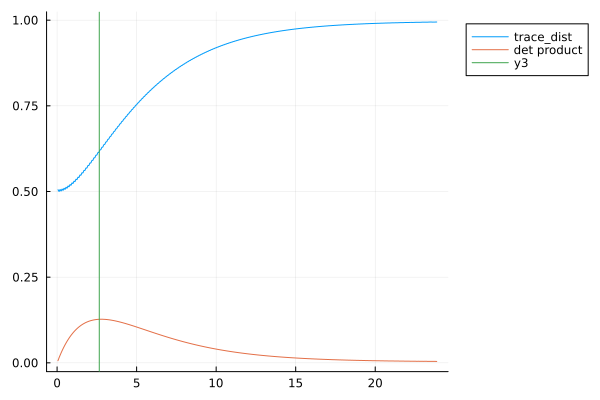

In [15]:
trace_sim = [abs(tr(ρ*σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]
det_sim = [2*sqrt(abs(det(ρ)*det(σ))) for (ρ, σ) in zip(ρˣ,ρʸ)]
det2_sim = [abs(det(ρ)*det(σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]

delta = [1 + abs(tr(ρ*σ)) - abs(det(ρ)*det(σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]

fid = trace_sim + det_sim
infid = [1-f for f in fid]

plot(tˣ, trace_sim,  label = "trace_dist")
plot!(tˣ, det_sim, label = "det product",legend = :outertopright) 
vline!([2*real(1/γᶠ)/3])

Fidelity for qubit can be written:

$F(\rho, \sigma) = \operatorname{tr}(\rho \sigma) + 2\sqrt{\det(\rho) \det(\sigma)} \approx \operatorname{tr}(\rho \sigma) + 8\det(\rho) \det(\sigma)$

$\Delta = 1-F \approx 1 - \operatorname{tr}(\rho \sigma) - 8\det(\rho) \det(\sigma)$

In [28]:
T = [real(tr(ρ*σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]
D = [abs(det(ρ)*det(σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]

a1 = 1 .- T .- 8 .* D;

Consider $F^2$

$F^2  =  \operatorname{tr}(\rho \sigma)^2 + 4\operatorname{tr}(\rho \sigma)\sqrt{\det(\rho) \det(\sigma)}+4\det(\rho) \det(\sigma) \approx \operatorname{tr}(\rho \sigma)^2 + 4\det(\rho) \det(\sigma) + 32 \operatorname{tr}(\rho \sigma) \det(\rho) \det(\sigma) $

It is more convenient to use infidelity therhold $\Delta = 1-F \ll 1$

In [43]:
#a2 = 1 .- sqrt.( T .^ 2 .+ 4 .* D .+ 32 .* T .* D);
a2 = 1 .- T .^ 2 .+ 4 .* D .+ 32 .* T .* D ;

$1 - 4\det(\rho) \det(\sigma) - 2\operatorname{tr}(\rho \sigma) + \operatorname{tr}(\rho \sigma)^2 < \Delta(2-\operatorname{tr}(\rho \sigma)) - \Delta^2$

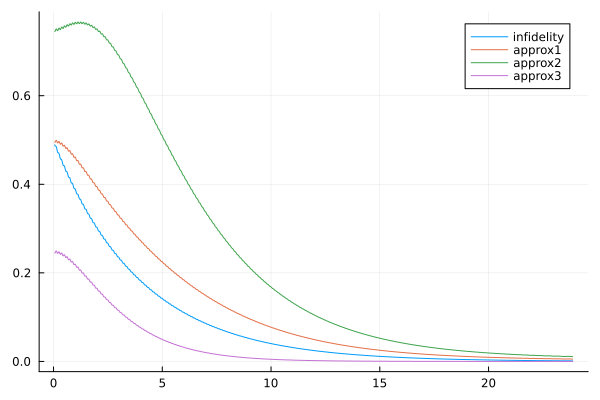

In [44]:

a3 = 1 .- 4 .* D .- 2 .* T + T .^ 2


#appr1 = [1-real(tr(ρ*σ))+8*abs(det(ρ)*det(σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]
#appr2 = [1-real(tr(ρ*σ))+8*abs(det(ρ)*det(σ)) for (ρ, σ) in zip(ρˣ,ρʸ)]

plot(tˣ, infid,  label = "infidelity")
plot!(tˣ, a1,  label = "approx1")
plot!(tˣ, a2,  label = "approx2")
plot!(tˣ, a3,  label = "approx3")


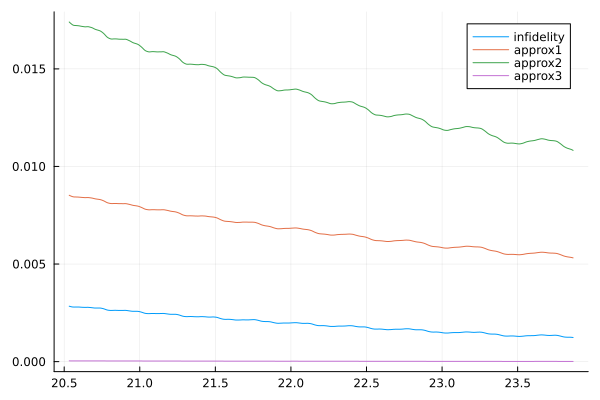

In [45]:
plot(tˣ[end-500:end], infid[end-500:end],  label = "infidelity")
plot!(tˣ[end-500:end], a1[end-500:end],  label = "approx1")
plot!(tˣ[end-500:end], a2[end-500:end],  label = "approx2")
plot!(tˣ[end-500:end], a3[end-500:end],  label = "approx3")

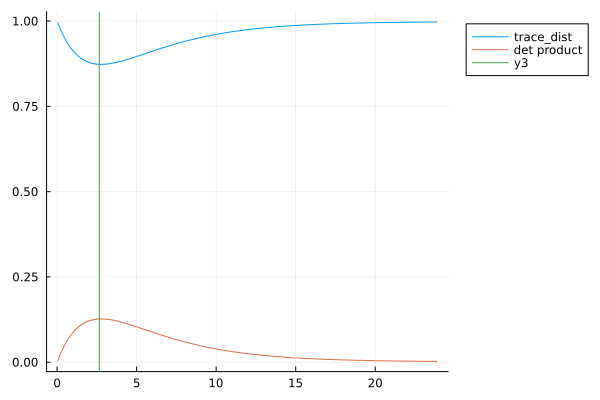

In [5]:
Hˢⁱᵐ = [ 25.133 0+0im
          0.    -25.133  ] / 2

Jˢⁱᵐ  = DenseOperator(basis,[ 0    sqrt(γᶠ)
                              0.   0+0im    ])
                              
ρ0 = DenseOperator(basis, ρˣ[1])

tˢⁱᵐ, ρˢⁱᵐ  = timeevolution.master(convert.(Float64,tˣ), ρ0, DenseOperator(basis, Hˢⁱᵐ), [Jˢⁱᵐ])

trace_sim = [abs(tr(ρ*σ.data)) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]
det_sim = [2*sqrt(abs(det(ρ)*det(σ.data))) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]
det2_sim = [abs(det(ρ)*det(σ.data)) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]

delta = [1 + abs(tr(ρ*σ.data)) - abs(det(ρ)*det(σ.data)) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]

fid = trace_sim + det_sim
infid = [1-f for f in fid]

plot(tˢⁱᵐ, trace_sim,  label = "trace_dist")
plot!(tˢⁱᵐ, det_sim, label = "det product",legend = :outertopright) 
vline!([2*real(1/γᶠ)/3])

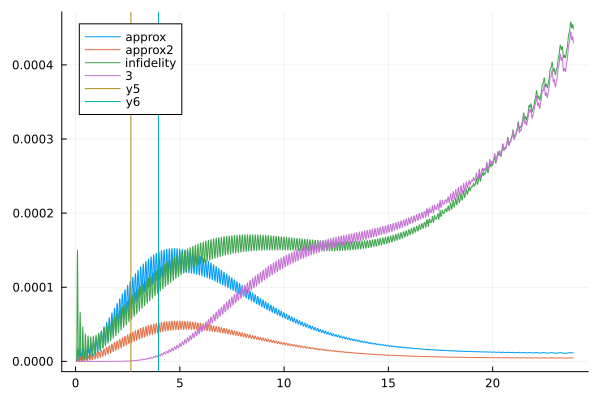

In [14]:
appr = [(-4*real(det(ρ)*det(σ.data))-2*real(tr(ρ*σ.data))+real(tr(ρ*σ.data))^2 + 1)*5 for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]

ineq = [-4*abs(det(ρ)*det(σ.data))-2*abs(tr(ρ*σ.data))+abs(tr(ρ*σ.data))^2 + 1 for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]

appr2 = [(-4*real(det(ρ)*det(σ.data))-2*real(tr(ρ*σ.data))+real(tr(ρ*σ.data))^2 + 1)*2*(1-(1-real(tr(ρ*σ.data)))) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]

appr3 = [appr[i]*1e-9*(i-200)^3 for i in 1:length(appr)]

#appr3 = [1-real(tr(ρ*σ.data))+8*abs(det(ρ)*det(σ.data)) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]


plot(tˢⁱᵐ, appr,  label = "approx")
plot!(tˢⁱᵐ, appr2,  label = "approx2")
plot!(tˢⁱᵐ, infid, label = "infidelity") 
plot!(tˢⁱᵐ, appr3, label = "3") 
vline!([2*real(1/γᶠ)/3])
vline!([real(1/γᶠ)])

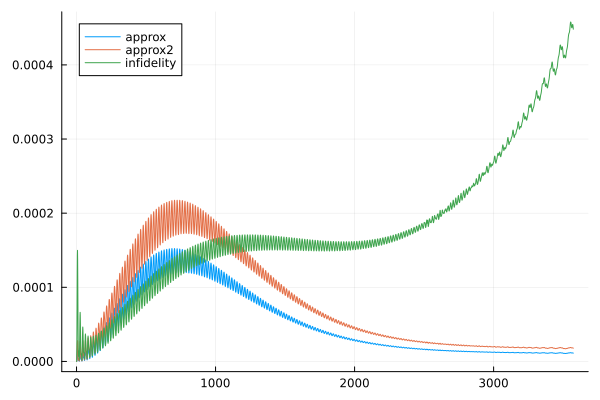

In [57]:
plot(appr,  label = "approx")
plot!(appr2,  label = "approx2")
plot!( infid, label = "infidelity") 

In [7]:
maximum(det_sim)

0.1258467913699157

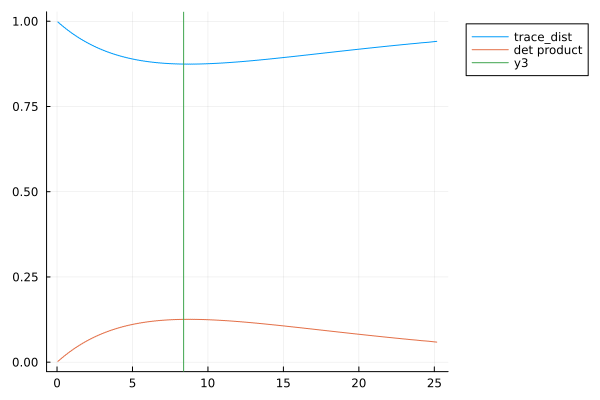

In [8]:
#println("Simulating Lindblad form")


Hˢⁱᵐ = [ 25.133 0+0im
          0.    -25.133  ] / 2

Jˢⁱᵐ  = DenseOperator(basis,[ 0    sqrt(γᶠ)
                              0.   0+0im    ])
                              
ρ0 = DenseOperator(basis, ρˣ[1])

tˢⁱᵐ, ρˢⁱᵐ  = timeevolution.master(convert.(Float64,tˣ), ρ0, DenseOperator(basis, Hˢⁱᵐ), [Jˢⁱᵐ])

trace_sim = [abs(tr(ρ*σ.data)) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]
det_sim = [2*sqrt(abs(det(ρ)*det(σ.data))) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]
det2_sim = [abs(det(ρ)*det(σ.data)) for (ρ, σ) in zip(ρˣ,ρˢⁱᵐ)]
fid = trace_sim + det_sim

plot(tˢⁱᵐ, trace_sim,  label = "trace_dist")
plot!(tˢⁱᵐ, det_sim, label = "det product",legend = :outertopright) 
vline!([2*real(1/γᶠ)/3])

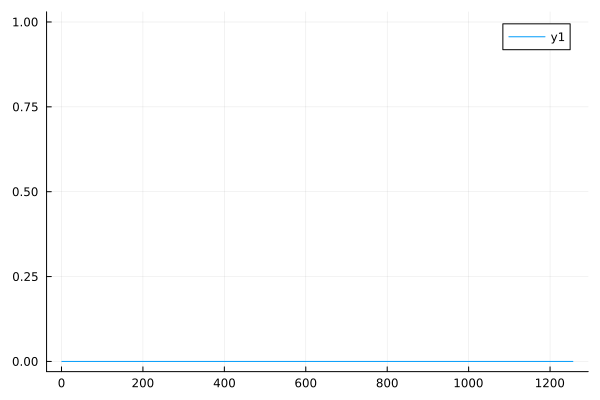

In [26]:
plot(delta)

In [50]:
length(delta)

1256

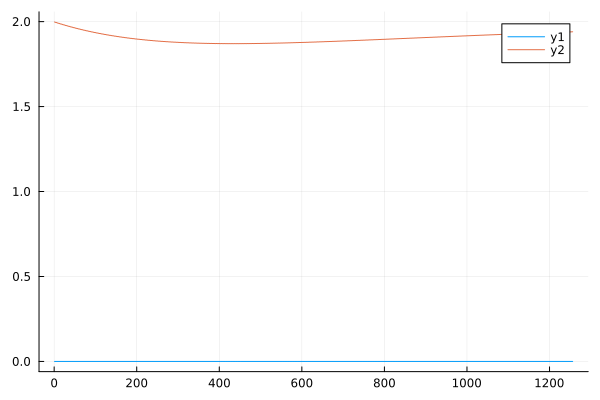

In [42]:
plot(infid)
plot!(delta)

$F(\rho, \sigma) = \operatorname{tr}(\rho \sigma) + 2\sqrt{\det(\rho) \det(\sigma)}$

$\operatorname{tr}(\rho \sigma) + 2\sqrt{\det(\rho) \det(\sigma)} > 0.999$

$2\sqrt{\det(\rho) \det(\sigma)} > 0.999 - \operatorname{tr}(\rho \sigma)$

$\sqrt{\det(\rho) \det(\sigma)} > (0.999 - \operatorname{tr}(\rho \sigma))/2$

$\det(\rho) \det(\sigma) > (0.999 - \operatorname{tr}(\rho \sigma))^2/4$

$4\det(\rho) \det(\sigma) - 0.999^2 + 2\cdot0.999\cdot\operatorname{tr}(\rho \sigma) - \operatorname{tr}(\rho \sigma)^2 > 0$

$\det(\rho) \det(\sigma) > ((1-\delta) - \operatorname{tr}(\rho \sigma))^2/4$

$4\det(\rho) \det(\sigma) > (1-\delta)^2 - 2 (1-\delta)\operatorname{tr}(\rho \sigma)+\operatorname{tr}(\rho \sigma)^2$

$4\det(\rho) \det(\sigma) > 1-2\delta+\delta^2 - 2\operatorname{tr}(\rho \sigma)+\delta\operatorname{tr}(\rho \sigma)+\operatorname{tr}(\rho \sigma)^2$

$4\det(\rho) \det(\sigma) + 2\operatorname{tr}(\rho \sigma)- \operatorname{tr}(\rho \sigma)^2 - 1 > -2\delta+\delta^2 +\delta\operatorname{tr}(\rho \sigma)$

$4\det(\rho) \det(\sigma) + 2\operatorname{tr}(\rho \sigma)- \operatorname{tr}(\rho \sigma)^2 - 1 > \delta^2 +\delta(\operatorname{tr}(\rho \sigma) -2) \approx \delta$ for $\delta \ll 1$

$1 - 4\det(\rho) \det(\sigma) - 2\operatorname{tr}(\rho \sigma) + \operatorname{tr}(\rho \sigma)^2 < -\delta^2-\delta(\operatorname{tr}(\rho \sigma) -2) $

$\lim_{\delta \to +0} \left(-\delta^2-\delta(\operatorname{tr}(\rho \sigma) -2)\right) =  \lim_{\delta \to +0} \delta(2-\operatorname{tr}(\rho \sigma))$

$(1 - 4\det(\rho) \det(\sigma) - 2\operatorname{tr}(\rho \sigma) + \operatorname{tr}(\rho \sigma)^2)^2 < \delta^2$

$1 - 4\det(\rho) \det(\sigma) - 2\operatorname{tr}(\rho \sigma) + \operatorname{tr}(\rho \sigma)^2 < \delta(2-\operatorname{tr}(\rho \sigma)) $

$1/x = 1 - (x-1) + (x-1)^2 + ...$

$1/(2-\operatorname{tr}(\rho \sigma)) = 1-(1-\operatorname{tr}(\rho \sigma))+(1-\operatorname{tr}(\rho \sigma))^2...$

In [10]:
x = 0.00001 
1/x

99999.99999999999

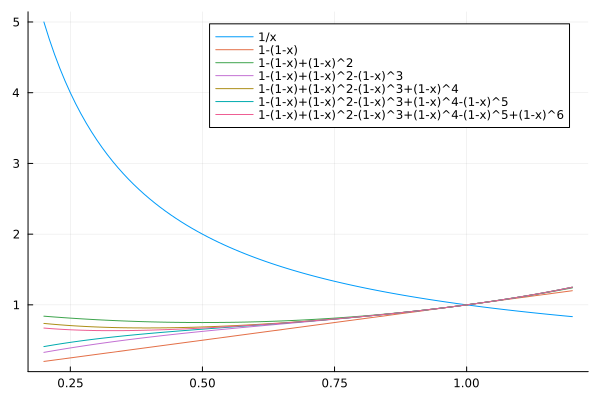

In [11]:
x_range = [0.2 : 0.01 : 1.2]
y0 = [1.0 / x for x in x_range...]
y1 = [1.0-(1-x) for x in x_range...]
y2 = [1.0-(1-x)+(1-x)^2 for x in x_range...]
y3 = [1.0-(1-x)+(1-x)^2-(1-x)^3 for x in x_range...]
y4 = [1.0-(1-x)+(1-x)^2-(1-x)^3+(1-x)^4 for x in x_range...]
y5 = [1.0-(1-x)+(1-x)^2-(1-x)^3+(1-x)^4-(1-x)^5 for x in x_range...]
y6 = [1.0-(1-x)+(1-x)^2-(1-x)^3+(1-x)^4-(1-x)^5+(1-x)^6 for x in x_range...]
plot(x_range..., y0, label = "1/x")
plot!(x_range..., y1, label = "1-(1-x) ")
plot!(x_range..., y2, label = "1-(1-x)+(1-x)^2")
plot!(x_range..., y3, label = "1-(1-x)+(1-x)^2-(1-x)^3")
plot!(x_range..., y4, label = "1-(1-x)+(1-x)^2-(1-x)^3+(1-x)^4")
plot!(x_range..., y5, label = "1-(1-x)+(1-x)^2-(1-x)^3+(1-x)^4-(1-x)^5")
plot!(x_range..., y6, label = "1-(1-x)+(1-x)^2-(1-x)^3+(1-x)^4-(1-x)^5+(1-x)^6")